In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import seaborn as sns
# from torch.utils.tensorboard import SummaryWriter
%tensorflow_version 1.x
from tensorboardcolab import TensorBoardColab
import matplotlib

# Part I: Image Classification
We will use the Fasion MNIST dataset available in torchvision.datasets.FashionMNIST for training our model. Fashion MNIST has 10 classes and 60000 train + validation images and 10000 test images.

## Dataloader:
Use the dataloader from torch.utils.data.DataLoader. This tutorial gives an example of how to use a torchvision dataset with the dataloader class. We will cast the problem as a 10 way classification problem. So the labels will be from 0 to 9. To prepare the data for the task use torchvision.transforms.ToTensor to convert uint8 values from 0 to 255, to normalized float values in range 0 to 1. Once you have the dataloader, sample a few images and display them along with their class.

In [0]:
batch_size = 100

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False, num_workers=2)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [0]:
#Training
n_training_samples = 40000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 10000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 10000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [0]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, sampler=test_sampler, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, batch_size=1, sampler=val_sampler, num_workers=2)

In [0]:
def imshow(img):
    img = img * 255     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


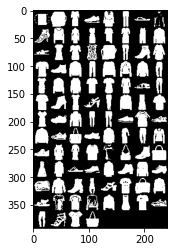

    8     8     3     7


In [0]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
images[1].shape

torch.Size([1, 28, 28])

##CNN:
Once you have the data loader, write a convolutional neural network using torch.nn.Module. This tutorial gives an example of how to write a neural network in pytorch. Our CNNs will use a convolutional layer (torch.nn.Conv2d), max pooling layer (torch.nn.MaxPool2d) and Rectilinear Unit as non-linearity (torch.nn.ReLU). The architecture of your neural network should be 2 conv layers, 32 channels each, where each conv layer will be followed by a ReLU followed by a maxpool. This should be followed by 2 fully connected networks. Apply ReLU after the first fc layer (but not after the last fully connected layer). You should play around with different kinds of non linearities and differetn number of channels to improve your result.

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)  # 6*6 from image dimension
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
# https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

## Loss Function and Optimizer: 
Now that you have the predictor (CNN) and the dataloader, you need to define the loss function and the optimizer to start training your CNN. You will use cross entropy loss (torch.nn.CrossEntropyLoss) as the prediction loss. Train your neural network using Adam using a learning rate of 0.01 (torch.optim.Adam). Run the training loop Until convergence. Try different optimizers, different learning rates and different values of weight decay (which is the same a L2 regularization).

In [0]:
net = Net()

In [0]:
num_epochs = 8
num_classes = 10
learning_rate = 0.0009

In [0]:
#Loss function
loss_fn = torch.nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)

In [0]:
#tb = TensorBoardColab()

In [0]:
# Train the model
total_step = len(trainloader)
loss_list = []
acc_list = []
acc_i = []
val_acc_list = []
val_i = []
out = []
for epoch in range(num_epochs):
    correct_sum = 0
    total_sum = 0
    for i, (images, labels) in enumerate(trainloader):
        # Run the forward pass
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_sum += total 
        correct_sum += correct

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
        #tb.save_value('Train Accuracy over Epochs', 'train accuracy', i, correct / total)
    acc_list.append(correct_sum / total_sum)
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        i = 0
        for images, labels in valloader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            i += 1
            if epoch == 1:
              out.append([images, predicted, labels])
        #tb.save_value('Val Accuracy over Epochs', 'val accuracy', i, correct / total)
        val_acc_list.append(correct / total)
        print('Validation Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


Epoch [1/8], Step [100/400], Loss: 0.4090, Accuracy: 85.00%
Epoch [1/8], Step [200/400], Loss: 0.3722, Accuracy: 85.00%
Epoch [1/8], Step [300/400], Loss: 0.3583, Accuracy: 89.00%
Epoch [1/8], Step [400/400], Loss: 0.3144, Accuracy: 86.00%
Validation Accuracy of the model on the 10000 test images: 88.44 %
Epoch [2/8], Step [100/400], Loss: 0.3600, Accuracy: 86.00%
Epoch [2/8], Step [200/400], Loss: 0.2357, Accuracy: 93.00%
Epoch [2/8], Step [300/400], Loss: 0.3220, Accuracy: 89.00%
Epoch [2/8], Step [400/400], Loss: 0.2425, Accuracy: 94.00%
Validation Accuracy of the model on the 10000 test images: 88.79 %
Epoch [3/8], Step [100/400], Loss: 0.2865, Accuracy: 90.00%
Epoch [3/8], Step [200/400], Loss: 0.2666, Accuracy: 90.00%
Epoch [3/8], Step [300/400], Loss: 0.2088, Accuracy: 91.00%
Epoch [3/8], Step [400/400], Loss: 0.2233, Accuracy: 90.00%
Validation Accuracy of the model on the 10000 test images: 91.0 %
Epoch [4/8], Step [100/400], Loss: 0.1062, Accuracy: 94.00%
Epoch [4/8], Step [2

In [0]:
torch.save(net.state_dict(), './models/model_{}.pth'.format("classification_net"))

In [0]:
# Test the model
net.eval()
images_arr = []
pred_arr = []
actual_arr = []
with torch.no_grad():
    correct = 0
    total = 0
    i = 0
    for images, labels in testloader:
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        images_arr.append(images)
        pred_arr.append(predicted)
        actual_arr.append(labels)
        #tb.save('Test Accuracy over Epochs', 'test accuracy', i, correct / total)
        i += 1

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
#torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

Test Accuracy of the model on the 10000 test images: 90.58 %


In [0]:
# https://discuss.pytorch.org/t/how-to-check-and-read-confusion-matrix/41835/5
nb_classes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
confusion_matrix_val = torch.zeros(nb_classes, nb_classes)
val_a = np.zeros(10)
test_a = np.zeros(10)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(valloader):
        #inputs = inputs.to(device)
        #classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                val_a[t.int()] += 1
                confusion_matrix_val[t.long(), p.long()] += 1

print(confusion_matrix_val)
nb_classes = 10

confusion_matrix_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        #inputs = inputs.to(device)
        #classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                test_a[t.int()] += 1
                confusion_matrix_test[t.long(), p.long()] += 1

print(confusion_matrix_test)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f46c609d908>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f46c609d908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/l

tensor([[8.4700e+02, 1.0000e+00, 1.9000e+01, 1.9000e+01, 0.0000e+00, 0.0000e+00,
         1.0500e+02, 0.0000e+00, 5.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0030e+03, 0.0000e+00, 1.1000e+01, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2000e+01, 0.0000e+00, 9.2800e+02, 1.7000e+01, 1.6000e+01, 0.0000e+00,
         8.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1000e+01, 6.0000e+00, 3.0000e+00, 9.0800e+02, 1.0000e+01, 0.0000e+00,
         1.8000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 8.5000e+01, 2.4000e+01, 7.6500e+02, 1.0000e+00,
         1.1700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7000e+02,
         0.0000e+00, 7.0000e+00, 0.0000e+00, 1.0000e+01],
        [6.5000e+01, 1.0000e+00, 5.4000e+01, 1.9000e+01, 1.1000e+01, 0.0000e+00,
         8.1100e+02, 0.0000e+00, 3.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000

In [0]:
val_a, test_a

(array([ 996., 1016., 1057.,  957.,  993.,  987.,  964., 1003., 1032.,
         995.]),
 array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]))

In [0]:
[847/996, 1003/1016, 928/1057, 908/957, 765/993, 970/987, 811/964, 962/1003, 1014/1032, 965/995], [828/1000, .985, .875, .926, .721, .984, .829, .970, .977, .963]

([0.8504016064257028,
  0.9872047244094488,
  0.8779564806054873,
  0.9487983281086729,
  0.770392749244713,
  0.9827760891590679,
  0.8412863070539419,
  0.959122632103689,
  0.9825581395348837,
  0.9698492462311558],
 [0.828, 0.985, 0.875, 0.926, 0.721, 0.984, 0.829, 0.97, 0.977, 0.963])

In [0]:
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, data[i, j], **kw)
            texts.append(text)

    return texts

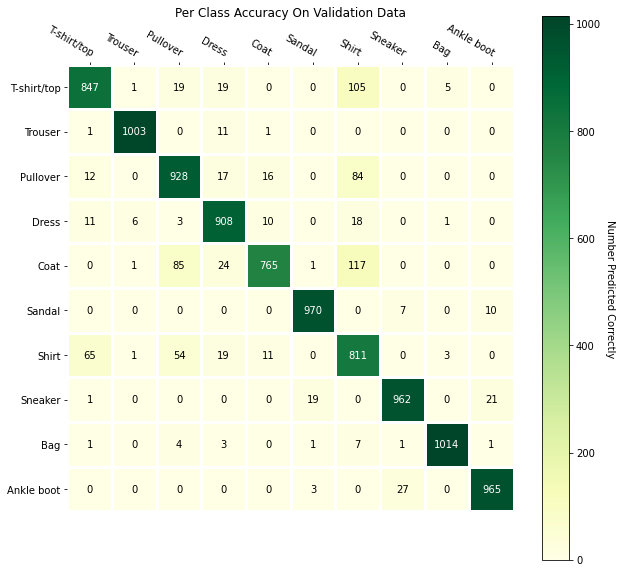

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
vegetables = ["T-shirt/top",
"Trouser",
"Pullover",
"Dress",
"Coat",
"Sandal",
"Shirt",
"Sneaker",
"Bag",
"Ankle boot"]
farmers = vegetables
im, cbar = heatmap(confusion_matrix_val.numpy().astype(int), vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="Number Predicted Correctly")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")
plt.title("Per Class Accuracy On Validation Data")

# fig.tight_layout()
plt.show()

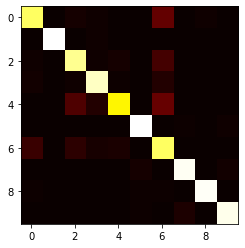

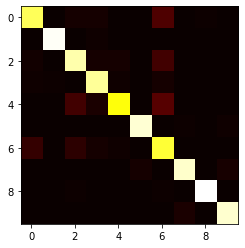

In [0]:
plt.imshow(confusion_matrix_test.numpy(), cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(confusion_matrix_val.numpy(), cmap='hot', interpolation='nearest')
plt.show()

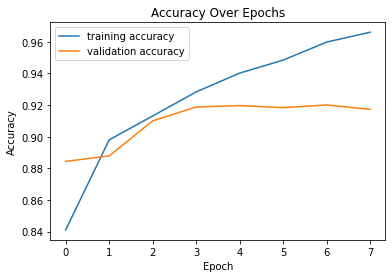

In [0]:
# plt.plot(val_acc_list, np.arange(8))
# plt.plot(acc_list, np.arange(0, 8, .25))
plt.plot(np.arange(8), acc_list, label="training accuracy")
plt.plot(np.arange(8), val_acc_list, label="validation accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [0]:
out[0]

[tensor([[[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
            -0.4242, -0.4242, -0.4242, -0.4242, -0.3478, -0.4242,  0.0976,
             2.0578,  1.8923,  0.2249, -0.4242, -0.3860, -0.4242, -0.4242,
            -0.4115, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
            -0.4242, -0.4242, -0.4115, -0.3860, -0.3860, -0.4242,  2.1469,
            -0.2206, -0.4242,  2.0451, -0.4242, -0.4242, -0.4115, -0.4115,
            -0.4242, -0.4115, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
            -0.4242, -0.4242, -0.4242, -0.3860, -0.4242,  0.4286,  1.8414,
            -0.4242, -0.4242,  1.1414,  0.3013, -0.4242, -0.3860, -0.4115,
            -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
            -0.4242, -

In [0]:
correct = []
incorrect = []
for val in out:
  pred = val[1]
  actual = val[2]
  if pred == actual:
    correct.append(val)
  else:
    incorrect.append(val)

In [0]:
c = [[],[],[],[],[],[],[],[],[],[]]
inc = [[],[],[],[],[],[],[],[],[],[]]
for v in correct:
  c[v[2]].append(v)
for v in incorrect:
  inc[v[2]].append(v)

In [0]:
classes = ["T-shirt/top",
"Trouser",
"Pullover",
"Dress",
"Coat",
"Sandal",
"Shirt",
"Sneaker",
"Bag",
"Ankle boot"]

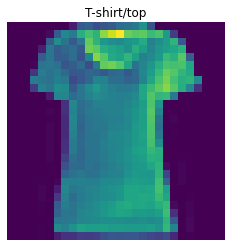

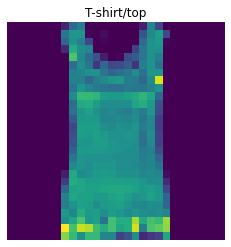

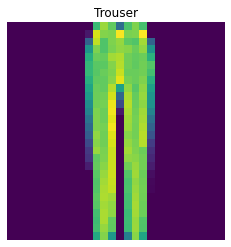

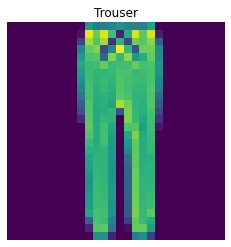

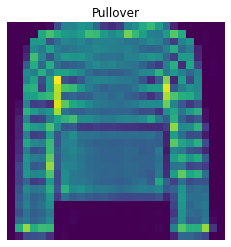

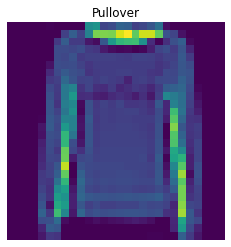

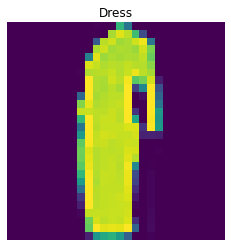

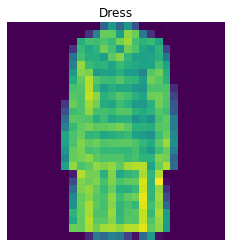

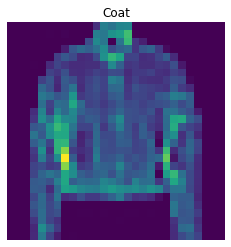

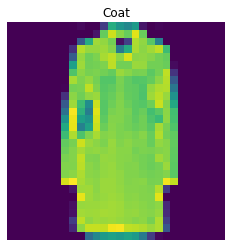

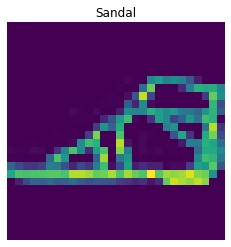

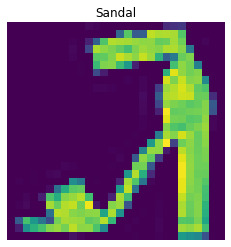

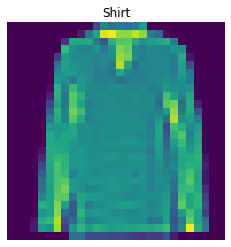

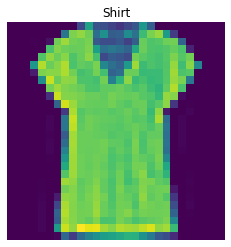

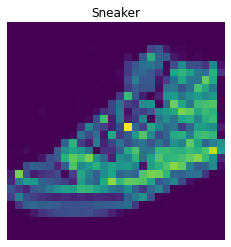

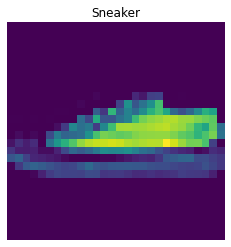

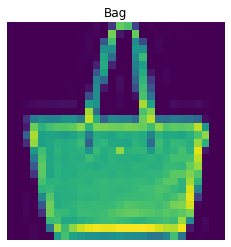

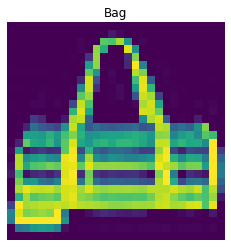

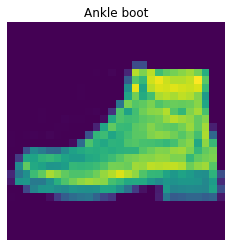

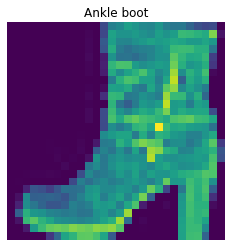

In [0]:
for c_val in c:
  for i in range(2):
    plt.imshow(c_val[i][0].numpy().squeeze())
    plt.title(classes[c_val[i][2]])
    plt.axis("off")
    plt.show()

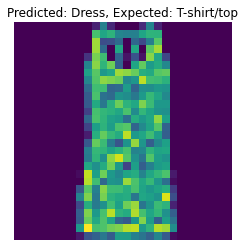

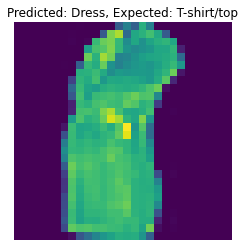

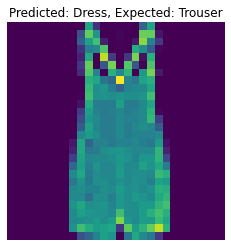

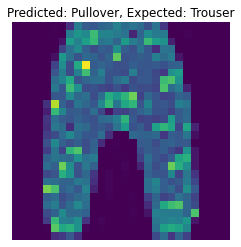

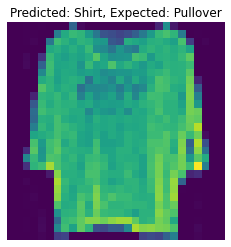

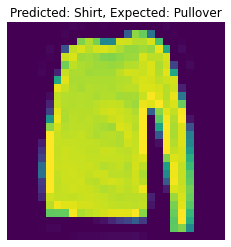

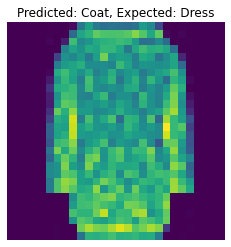

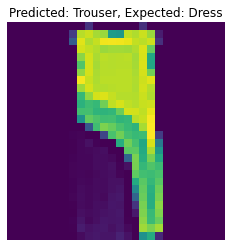

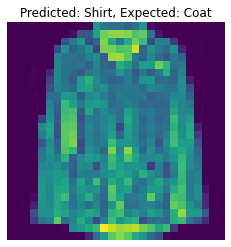

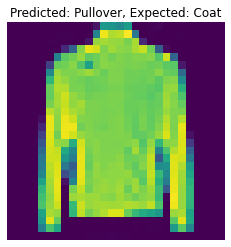

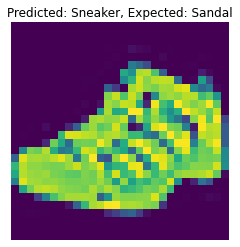

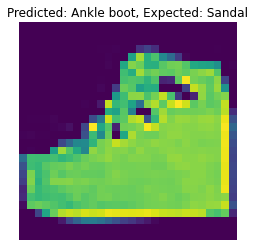

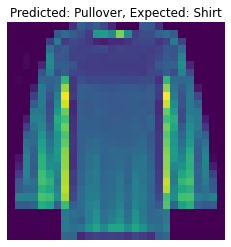

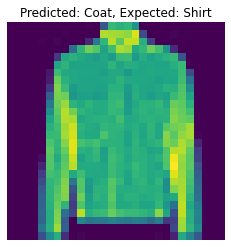

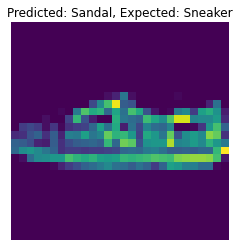

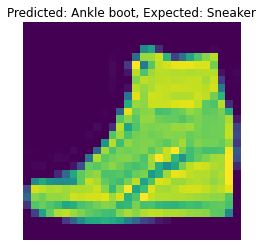

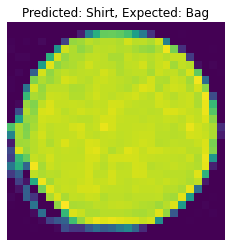

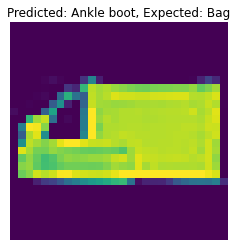

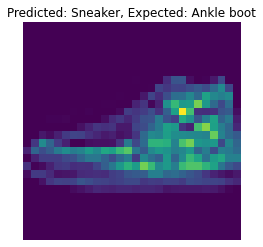

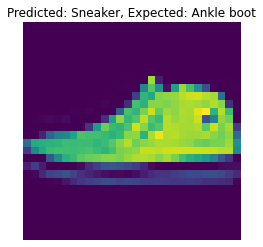

In [0]:
for c_val in inc:
  for j in range(2):
    plt.imshow(c_val[j][0].numpy().squeeze())
    plt.title("Predicted: " + classes[c_val[j][1]] + ", Expected: " + classes[c_val[j][2]])
    plt.axis("off")
    plt.show()

In [0]:
# https://stackoverflow.com/questions/58218165/googlenet-object-has-no-attribute-features
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.net = net
        # If you treat GooLeNet as a fixed feature extractor, disable the gradients and save some memory
        for p in self.net.parameters():
            p.requires_grad = False
        # Define which layers you are going to extract
        self.features = nn.Sequential(*list(self.net.children())[:4])

    def forward(self, x):
        return self.features(x)

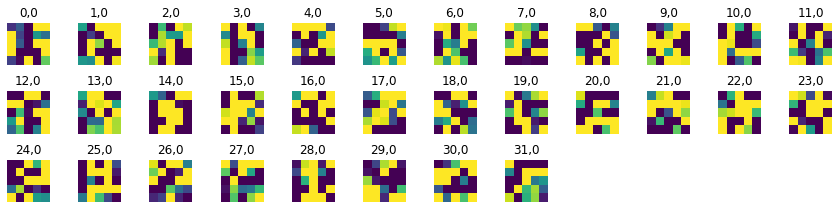

In [0]:
fe = FeatureExtractor()
plot_weights(fe, 0, single_channel = True)

##Results
Once you have trained your model, show the following results for the network:
Plot the train and validation accuracy during the training process.
Compute a per class accuracy of your classifier on the validation and test dataset. Which classes are the hardest to get? Show 2 images from each class which the network classifies correctly, and 2 more images where it classifies incorrectly.
Visualize the learned filters.

# Part II: Semantic Segmentation
Semantic Segmentation refers to labeling each pixel in the image to its correct object class. We will use the Mini Facade dataset. The starter code and data for this part is available here. Mini Facade dataset consists of images of different cities around the world and diverse architectural styles (in .jpg format), shown as the image on the left. It also contains semantic segmentation labels (in .png format) in 5 different classes: balcony, window, pillar, facade and others. Your task is to train a network to convert image on the left to the labels on the right. The color to label map is shown in the table below.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import os
import png
import torch
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from PIL import Image

##Dataloader
The starter code has the dataloader written for the Mini Facade. Split the data into a training and validation set, and you should evaluate on the test set only once, after you have tuned all your hyper parameters on the validation set.

In [0]:
!unzip ./starter_set.zip

Archive:  ./starter_set.zip
  inflating: starter_set/.DS_Store   
  inflating: starter_set/colormap.png  
  inflating: starter_set/readme.txt  
   creating: starter_set/test_dev/
  inflating: starter_set/test_dev/.DS_Store  
  inflating: starter_set/test_dev/eecs442_0000.jpg  
  inflating: starter_set/test_dev/eecs442_0000.png  
  inflating: starter_set/test_dev/eecs442_0001.jpg  
  inflating: starter_set/test_dev/eecs442_0001.png  
  inflating: starter_set/test_dev/eecs442_0002.jpg  
  inflating: starter_set/test_dev/eecs442_0002.png  
  inflating: starter_set/test_dev/eecs442_0003.jpg  
  inflating: starter_set/test_dev/eecs442_0003.png  
  inflating: starter_set/test_dev/eecs442_0004.jpg  
  inflating: starter_set/test_dev/eecs442_0004.png  
  inflating: starter_set/test_dev/eecs442_0005.jpg  
  inflating: starter_set/test_dev/eecs442_0005.png  
  inflating: starter_set/test_dev/eecs442_0006.jpg  
  inflating: starter_set/test_dev/eecs442_0006.png  
  inflating: starter_set/test_dev

In [0]:
!unzip ./models.zip
!unzip ./output_test.zip
!unzip ./output_train.zip

Archive:  ./models.zip
  inflating: models/.DS_Store        
 extracting: models/__init__.py      
Archive:  ./output_test.zip
  inflating: output_test/.DS_Store   
 extracting: output_test/__init__.py  
Archive:  ./output_train.zip
 extracting: output_train/__init__.py  


In [0]:
class FacadeDataset(Dataset):
    def __init__(self, flag, dataDir='./starter_set', data_range=(0, 8), n_class=5, onehot=False):
        self.onehot = onehot
        assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
        print("load "+ flag+" dataset start")
        print("    from: %s" % dataDir)
        print("    range: [%d, %d)" % (data_range[0], data_range[1]))
        self.dataset = []
        for i in range(data_range[0], data_range[1]):
            img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

            pngreader = png.Reader(filename=os.path.join(dataDir,flag,'eecs442_%04d.png' % i))
            w,h,row,info = pngreader.read()
            label = np.array(list(row)).astype('uint8')

            # Normalize input image
            img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
            # Convert to n_class-dimensional onehot matrix
            label_ = np.asarray(label)
            label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
            for j in range(n_class):
                label[j, :] = label_ == j
            self.dataset.append((img, label))
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        label = torch.FloatTensor(label)
        if not self.onehot:
            label = torch.argmax(label, dim=0)
        else:
            label = label.long()

        return torch.FloatTensor(img), torch.LongTensor(label)


##CNN
The starter code in part3/train.py provides a dummy network. The output of the network should be 5 numbers for each pixel in the input image (HxWx5 sized output). Write a CNN with 5-6 convolution layers for this task. The convolution should be followed by ReLU. If you choose to use maxpool after the conv layer, you might consider using torch.nn.Upsample or torch.nn.ConvTranspose2d to finally match the resolution of the input image.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 23 bytes


In [0]:
pip install -r requirements.txt

     |████████████████████████████████| 655kB 4.8MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67161 sha256=996fcf644d01c4e00048542562bd9afe5e4b5fb89abccad946c15973b93f803d
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
  Created wheel for colormap: filename=colormap-1.0.3-cp36-none-any.whl size=15560 sha256=b8ed3a59e61a45e73fd26636fcc82e741f83d3ad11a0c26561a6d69ac6220d12
  Stored in directory: /root/.cache/pip/wheels/b5/c4/23/5f5d3e77fb0d00f44ee147a9cbb3acb641b9ebe2f3d5406c66
  Created wheel for easydev: filename=easydev-0.9.38-cp36-none-any.whl size=72215 sha256=ac231e94bb2af79a4537838abacd25d526aaeadaf4580784291a3834833028bc
  Stored in directory: /root/.cache/pip/wheels/38/93/b7/c4ee5cf6eb4011f7db6467465fe2fb280bbb224a61400bd8a6
Successfully built pypng colormap easydev


In [0]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
N_CLASS=5
train_loss = []
val_loss = []

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        self.layers = nn.Sequential(
            #########################################
            ###        TODO: Add more layers      ###
            #########################################
            nn.Conv2d(3, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.ConvTranspose2d(512, 256, 5, stride=2),
            nn.ConvTranspose2d(256, 128, 3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, self.n_class, 3, stride=2, output_padding=1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    net = net.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
    end = time.time()
    print('[epoch %d] loss: %.3f elapsed time %.3f' %
          (epoch, running_loss, end-start))
    train_loss.append(running_loss)

def test(testloader, net, criterion, device, val=False):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print(losses / cnt)
    if (val):
      val_loss.append(losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))

    # print(losses / cnt)
    print("Average over all cases:", sum(aps) / 5)
    return None


def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                './{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1

def main():
    batch_size = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # TODO change data_range to include all train/evaluation/test data.
    # TODO adjust batch_size.
    #Training
    n_training_samples = 905
    train_sampler = SubsetRandomSampler(np.arange(n_training_samples - 114, dtype=np.int64))
    #Validation
    n_val_samples = 114
    val_sampler = SubsetRandomSampler(np.arange(n_training_samples - n_val_samples, n_training_samples, dtype=np.int64))
    #Test
    n_test_samples = 114
    test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
    train_data = FacadeDataset(flag='train', data_range=(0, n_training_samples), onehot=False)
    train_loader = DataLoader(train_data, sampler=train_sampler, num_workers=2, batch_size=batch_size)
    test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
    test_loader = DataLoader(test_data, sampler=test_sampler, num_workers=2, batch_size=batch_size)
    ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
    ap_loader = DataLoader(ap_data, batch_size=batch_size)

    name = 'starter_net'
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss() #TODO decide loss
    optimizer = torch.optim.Adam(net.parameters(), .00008, weight_decay=1e-5)

    print('\nStart training')
    for epoch in range(45): #TODO decide epochs
        print('-----------------Epoch = %d-----------------' % (epoch+1))
        train(train_loader, net, criterion, optimizer, device, epoch+1)
        # TODO create your evaluation set, load the evaluation set and test on evaluation set
        #evaluation_loader = train_loader
        #test(evaluation_loader, net, criterion, device)
        evaluation_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
        test(evaluation_loader, net, criterion, device, val=True)

    print('\nFinished Training, Testing on test set')
    test(test_loader, net, criterion, device)
    print('\nGenerating Unlabeled Result')
    result = get_result(test_loader, net, device, folder='output_test')

    torch.save(net.state_dict(), './models/model_{}.pth'.format(name))

    cal_AP(ap_loader, net, criterion, device)

In [0]:
main()

load train dataset start
    from: ./starter_set
    range: [0, 905)
load dataset done
load test_dev dataset start
    from: ./starter_set
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./starter_set
    range: [0, 114)
load dataset done

Start training
-----------------Epoch = 1-----------------


100%|██████████| 791/791 [00:14<00:00, 52.88it/s]


[epoch 1] loss: 1.270 elapsed time 14.962


100%|██████████| 114/114 [00:02<00:00, 55.98it/s]


1.0587933978490662
-----------------Epoch = 2-----------------


100%|██████████| 791/791 [00:14<00:00, 52.87it/s]


[epoch 2] loss: 0.692 elapsed time 14.965


100%|██████████| 114/114 [00:02<00:00, 55.49it/s]


0.9641944096799482
-----------------Epoch = 3-----------------


100%|██████████| 791/791 [00:14<00:00, 52.84it/s]


[epoch 3] loss: 1.540 elapsed time 14.973


100%|██████████| 114/114 [00:02<00:00, 56.94it/s]


0.8989247052293075
-----------------Epoch = 4-----------------


100%|██████████| 791/791 [00:15<00:00, 52.57it/s]


[epoch 4] loss: 0.604 elapsed time 15.052


100%|██████████| 114/114 [00:02<00:00, 54.95it/s]


0.8622355262438456
-----------------Epoch = 5-----------------


100%|██████████| 791/791 [00:15<00:00, 52.65it/s]


[epoch 5] loss: 0.718 elapsed time 15.029


100%|██████████| 114/114 [00:02<00:00, 56.17it/s]


0.8479235386639311
-----------------Epoch = 6-----------------


100%|██████████| 791/791 [00:14<00:00, 52.84it/s]


[epoch 6] loss: 0.825 elapsed time 14.977


100%|██████████| 114/114 [00:02<00:00, 56.05it/s]


0.8103006050774926
-----------------Epoch = 7-----------------


100%|██████████| 791/791 [00:14<00:00, 52.97it/s]


[epoch 7] loss: 0.834 elapsed time 14.936


100%|██████████| 114/114 [00:02<00:00, 55.88it/s]


0.803008045805128
-----------------Epoch = 8-----------------


100%|██████████| 791/791 [00:14<00:00, 52.89it/s]


[epoch 8] loss: 0.920 elapsed time 14.959


100%|██████████| 114/114 [00:02<00:00, 56.09it/s]


0.7894886269381172
-----------------Epoch = 9-----------------


100%|██████████| 791/791 [00:15<00:00, 52.61it/s]


[epoch 9] loss: 0.996 elapsed time 15.045


100%|██████████| 114/114 [00:02<00:00, 55.67it/s]


0.7973683424163283
-----------------Epoch = 10-----------------


100%|██████████| 791/791 [00:15<00:00, 52.64it/s]


[epoch 10] loss: 0.671 elapsed time 15.029


100%|██████████| 114/114 [00:02<00:00, 55.05it/s]


0.7707921726661816
-----------------Epoch = 11-----------------


100%|██████████| 791/791 [00:15<00:00, 52.66it/s]


[epoch 11] loss: 0.967 elapsed time 15.023


100%|██████████| 114/114 [00:02<00:00, 56.08it/s]


0.7550357449472996
-----------------Epoch = 12-----------------


100%|██████████| 791/791 [00:14<00:00, 52.95it/s]


[epoch 12] loss: 0.634 elapsed time 14.944


100%|██████████| 114/114 [00:02<00:00, 55.54it/s]


0.7385744865526233
-----------------Epoch = 13-----------------


100%|██████████| 791/791 [00:15<00:00, 52.59it/s]


[epoch 13] loss: 0.667 elapsed time 15.045


100%|██████████| 114/114 [00:02<00:00, 56.21it/s]


0.7268755430715126
-----------------Epoch = 14-----------------


100%|██████████| 791/791 [00:14<00:00, 52.84it/s]


[epoch 14] loss: 0.839 elapsed time 14.974


100%|██████████| 114/114 [00:02<00:00, 56.18it/s]


0.7177393326633855
-----------------Epoch = 15-----------------


100%|██████████| 791/791 [00:15<00:00, 52.40it/s]


[epoch 15] loss: 0.675 elapsed time 15.098


100%|██████████| 114/114 [00:02<00:00, 56.25it/s]


0.7107868320063541
-----------------Epoch = 16-----------------


100%|██████████| 791/791 [00:15<00:00, 52.62it/s]


[epoch 16] loss: 0.809 elapsed time 15.038


100%|██████████| 114/114 [00:02<00:00, 54.30it/s]


0.6981550567505652
-----------------Epoch = 17-----------------


100%|██████████| 791/791 [00:15<00:00, 52.61it/s]


[epoch 17] loss: 0.682 elapsed time 15.039


100%|██████████| 114/114 [00:02<00:00, 56.15it/s]


0.7305940217093417
-----------------Epoch = 18-----------------


100%|██████████| 791/791 [00:15<00:00, 52.43it/s]


[epoch 18] loss: 0.532 elapsed time 15.091


100%|██████████| 114/114 [00:02<00:00, 54.34it/s]


0.6867924222820684
-----------------Epoch = 19-----------------


100%|██████████| 791/791 [00:15<00:00, 52.68it/s]


[epoch 19] loss: 0.740 elapsed time 15.018


100%|██████████| 114/114 [00:02<00:00, 55.15it/s]


0.6577735313198023
-----------------Epoch = 20-----------------


100%|██████████| 791/791 [00:15<00:00, 52.69it/s]


[epoch 20] loss: 0.672 elapsed time 15.018


100%|██████████| 114/114 [00:02<00:00, 55.12it/s]


0.6411076535781225
-----------------Epoch = 21-----------------


100%|██████████| 791/791 [00:15<00:00, 52.72it/s]


[epoch 21] loss: 0.510 elapsed time 15.009


100%|██████████| 114/114 [00:02<00:00, 55.74it/s]


0.6371899150442659
-----------------Epoch = 22-----------------


100%|██████████| 791/791 [00:15<00:00, 52.71it/s]


[epoch 22] loss: 0.708 elapsed time 15.013


100%|██████████| 114/114 [00:02<00:00, 55.26it/s]


0.651796128143344
-----------------Epoch = 23-----------------


100%|██████████| 791/791 [00:15<00:00, 52.70it/s]


[epoch 23] loss: 0.555 elapsed time 15.014


100%|██████████| 114/114 [00:02<00:00, 55.95it/s]


0.6280704796837088
-----------------Epoch = 24-----------------


100%|██████████| 791/791 [00:15<00:00, 52.63it/s]


[epoch 24] loss: 0.710 elapsed time 15.032


100%|██████████| 114/114 [00:02<00:00, 56.27it/s]


0.6371113637037444
-----------------Epoch = 25-----------------


100%|██████████| 791/791 [00:15<00:00, 52.69it/s]


[epoch 25] loss: 0.484 elapsed time 15.015


100%|██████████| 114/114 [00:02<00:00, 56.16it/s]


0.6076376869490272
-----------------Epoch = 26-----------------


100%|██████████| 791/791 [00:15<00:00, 52.61it/s]


[epoch 26] loss: 0.562 elapsed time 15.038


100%|██████████| 114/114 [00:02<00:00, 54.31it/s]


0.6186329468823316
-----------------Epoch = 27-----------------


100%|██████████| 791/791 [00:15<00:00, 52.63it/s]


[epoch 27] loss: 0.651 elapsed time 15.036


100%|██████████| 114/114 [00:02<00:00, 55.53it/s]


0.5897263844023671
-----------------Epoch = 28-----------------


100%|██████████| 791/791 [00:15<00:00, 52.51it/s]


[epoch 28] loss: 0.591 elapsed time 15.068


100%|██████████| 114/114 [00:02<00:00, 54.40it/s]


0.5912737475152601
-----------------Epoch = 29-----------------


100%|██████████| 791/791 [00:15<00:00, 52.59it/s]


[epoch 29] loss: 0.462 elapsed time 15.045


100%|██████████| 114/114 [00:02<00:00, 54.16it/s]


0.5905482721956152
-----------------Epoch = 30-----------------


100%|██████████| 791/791 [00:14<00:00, 53.22it/s]


[epoch 30] loss: 0.715 elapsed time 14.865


100%|██████████| 114/114 [00:02<00:00, 56.54it/s]


0.5744819790124893
-----------------Epoch = 31-----------------


100%|██████████| 791/791 [00:15<00:00, 52.62it/s]


[epoch 31] loss: 0.391 elapsed time 15.039


100%|██████████| 114/114 [00:02<00:00, 55.83it/s]


0.5664549229437845
-----------------Epoch = 32-----------------


100%|██████████| 791/791 [00:14<00:00, 52.77it/s]


[epoch 32] loss: 0.292 elapsed time 14.992


100%|██████████| 114/114 [00:02<00:00, 54.10it/s]


0.5734368920849081
-----------------Epoch = 33-----------------


100%|██████████| 791/791 [00:15<00:00, 52.62it/s]


[epoch 33] loss: 0.486 elapsed time 15.036


100%|██████████| 114/114 [00:02<00:00, 54.93it/s]


0.5543032440177181
-----------------Epoch = 34-----------------


100%|██████████| 791/791 [00:15<00:00, 52.62it/s]


[epoch 34] loss: 0.305 elapsed time 15.038


100%|██████████| 114/114 [00:02<00:00, 55.96it/s]


0.5463610656167331
-----------------Epoch = 35-----------------


100%|██████████| 791/791 [00:15<00:00, 52.58it/s]


[epoch 35] loss: 0.519 elapsed time 15.045


100%|██████████| 114/114 [00:02<00:00, 55.79it/s]


0.532226124745712
-----------------Epoch = 36-----------------


100%|██████████| 791/791 [00:15<00:00, 52.58it/s]


[epoch 36] loss: 0.427 elapsed time 15.047


100%|██████████| 114/114 [00:02<00:00, 55.63it/s]


0.5322830213005083
-----------------Epoch = 37-----------------


100%|██████████| 791/791 [00:14<00:00, 52.77it/s]


[epoch 37] loss: 0.455 elapsed time 14.994


100%|██████████| 114/114 [00:02<00:00, 55.86it/s]


0.539074033498764
-----------------Epoch = 38-----------------


100%|██████████| 791/791 [00:14<00:00, 52.91it/s]


[epoch 38] loss: 0.354 elapsed time 14.956


100%|██████████| 114/114 [00:02<00:00, 54.87it/s]


0.5344428677569356
-----------------Epoch = 39-----------------


100%|██████████| 791/791 [00:14<00:00, 52.95it/s]


[epoch 39] loss: 0.366 elapsed time 14.943


100%|██████████| 114/114 [00:02<00:00, 54.97it/s]


0.5126364696444127
-----------------Epoch = 40-----------------


100%|██████████| 791/791 [00:15<00:00, 52.68it/s]


[epoch 40] loss: 0.438 elapsed time 15.019


100%|██████████| 114/114 [00:02<00:00, 54.57it/s]


0.5401052810382425
-----------------Epoch = 41-----------------


100%|██████████| 791/791 [00:15<00:00, 52.69it/s]


[epoch 41] loss: 0.267 elapsed time 15.017


100%|██████████| 114/114 [00:02<00:00, 55.36it/s]


0.5167857703932545
-----------------Epoch = 42-----------------


100%|██████████| 791/791 [00:14<00:00, 52.80it/s]


[epoch 42] loss: 0.387 elapsed time 14.987


100%|██████████| 114/114 [00:02<00:00, 56.28it/s]


0.5069766346561281
-----------------Epoch = 43-----------------


100%|██████████| 791/791 [00:14<00:00, 52.84it/s]


[epoch 43] loss: 0.410 elapsed time 14.973


100%|██████████| 114/114 [00:02<00:00, 56.68it/s]


0.5190850633539652
-----------------Epoch = 44-----------------


100%|██████████| 791/791 [00:14<00:00, 53.00it/s]


[epoch 44] loss: 0.427 elapsed time 14.933


100%|██████████| 114/114 [00:02<00:00, 55.49it/s]


0.5103845015952462
-----------------Epoch = 45-----------------


100%|██████████| 791/791 [00:15<00:00, 52.61it/s]


[epoch 45] loss: 0.517 elapsed time 15.039


100%|██████████| 114/114 [00:02<00:00, 55.16it/s]


0.5034478034889489

Finished Training, Testing on test set


100%|██████████| 114/114 [00:01<00:00, 81.68it/s]


0.9487951983485305

Generating Unlabeled Result


100%|██████████| 114/114 [00:01<00:00, 98.07it/s]


AP = 0.6650391528044352
AP = 0.7495223466019041
AP = 0.20047346249696912
AP = 0.8481419984297889
AP = 0.5634386704211363
Average over all cases: 0.6053231261508467


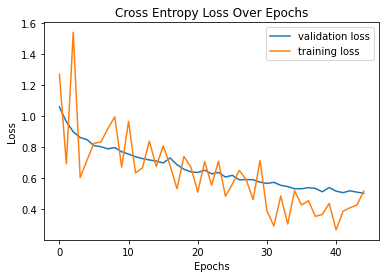

In [0]:
plt.plot(np.arange(0, 45), val_loss, label="validation loss")
plt.plot(np.arange(0, 45), train_loss, label="training loss")
plt.title("Cross Entropy Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [0]:
from google.colab import files

In [0]:
!zip -r ./output_custom.zip ./output_test

  adding: output_test/ (stored 0%)
  adding: output_test/x83.png (deflated 0%)
  adding: output_test/gt16.png (deflated 8%)
  adding: output_test/x101.png (deflated 0%)
  adding: output_test/gt22.png (deflated 8%)
  adding: output_test/x17.png (deflated 0%)
  adding: output_test/y58.png (deflated 0%)
  adding: output_test/gt27.png (deflated 10%)
  adding: output_test/y110.png (deflated 0%)
  adding: output_test/x113.png (deflated 0%)
  adding: output_test/y44.png (stored 0%)
  adding: output_test/x92.png (deflated 0%)
  adding: output_test/gt78.png (deflated 21%)
  adding: output_test/y75.png (stored 0%)
  adding: output_test/x0.png (deflated 0%)
  adding: output_test/gt93.png (deflated 2%)
  adding: output_test/x90.png (deflated 0%)
  adding: output_test/x107.png (deflated 0%)
  adding: output_test/x6.png (deflated 0%)
  adding: output_test/x69.png (deflated 0%)
  adding: output_test/gt98.png (deflated 4%)
  adding: output_test/gt73.png (deflated 4%)
  adding: output_test/gt10.png (de

In [0]:
files.download("./output_custom.zip")

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
net.load_state_dict(torch.load("/content/models/model_starter_net.pth"))

<All keys matched successfully>

In [0]:
from PIL import Image
im = Image.open("./building.jpg").convert('RGB')
img = plt.imread("./building.jpg")

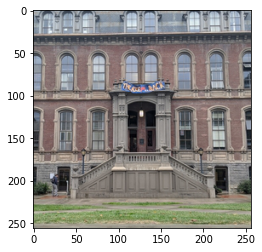

In [0]:
plt.imshow(im)

In [0]:
transform = transforms.Compose(
                   [transforms.Resize((256,256)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print(transform(im).size())
my_loader = DataLoader(transform(im), batch_size=1)
my_loader

torch.Size([3, 256, 256])


In [0]:
result = []
cnt = 1
with torch.no_grad():
    net = net.eval()
    cnt = 0
    for images in tqdm(my_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = net(im)[0].cpu().numpy()
        # c, h, w = output.shape
        # assert(c == N_CLASS)
        # y = np.zeros((h,w)).astype('uint8')
        # for i in range(N_CLASS):
        #     mask = output[i]>0.5
        #     y[mask] = i
        # #gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
        # save_label(y, './{}/y{}.png'.format(folder, "mine"))
        # #save_label(gt, './{}/gt{}.png'.format(folder, cnt))
        # plt.imsave(
        #     './{}/x{}.png'.format(folder, "mine"),
        #     ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

        # cnt += 1

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([1, 256, 256])


  0%|          | 0/3 [00:00<?, ?it/s]


AttributeError: ignored

In [0]:
n_test_samples = 115
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_data = FacadeDataset(flag='test_dev', data_range=(0,115), onehot=False)
test_loader = DataLoader(test_data, sampler=test_sampler, num_workers=2, batch_size=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
net.load_state_dict(torch.load("/content/models/model_starter_net.pth"))
get_result(test_loader, net, device, folder='output_test')

load test_dev dataset start
    from: ./starter_set
    range: [0, 115)
load dataset done


100%|██████████| 115/115 [00:09<00:00, 12.74it/s]
